In [15]:
# conda install -c menpo opencv
# https://stackoverflow.com/questions/23119413/how-do-i-install-python-opencv-through-conda
import cv2
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import numpy as np
import math
import itertools

from src.traffic_lanes_pipeline.merge_lines import merge_lines
from src.traffic_lanes_pipeline.lanes import extend_line
from src.traffic_lanes_pipeline.view_filter import limit_view
from src.traffic_lanes_pipeline.image_pipeline import process_image

from skimage.filters import threshold_otsu


## Greyscale the image

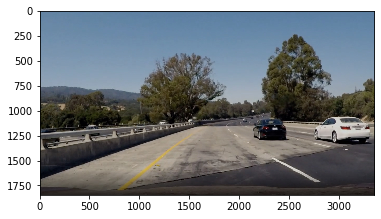

In [16]:
img_path = 'test_images/challenge2.jpg'
img = cv2.imread(img_path, cv2.IMREAD_COLOR)

# This is to compensate for the fact that 
# opencv image layers are stored in reverse order - BGR
# @alsosee https://www.pyimagesearch.com/2014/11/03/display-matplotlib-rgb-image/
img_color = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_color)



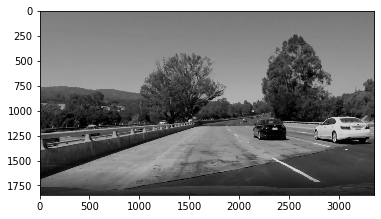

In [17]:
img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# cmap, vmin, vmax allow to print image as human expects it
plt.imshow(img_grey, cmap=cm.gray, vmin=0, vmax=255)

## Apply gradient filter to identify edges

Gradient filter can be applied to the grey scale image to identify
points on the where color intensity changes the most. 

On this example image these we can expect bright road lines to be picked 
up by the filter. 

Application of the GaussianBlur prior to Edge detection
reduces number of edgets that will be identified in the next step.

In [18]:
# Define a kernel size for Gaussian smoothing / blurring
# Note: this step is optional as cv2.Canny() applies a 5x5 Gaussian internally
kernel_size = 5
img_blur = cv2.GaussianBlur(img_grey,(kernel_size, kernel_size), 0)

In [19]:

thresholds = [(50, 150), (50, 200), (30, 200), (70, 200), 
              (50, 180), (50, 220), (50, 250),
              (100, 150), (100, 200), (100, 250),
              (150, 150), (150, 200), (150, 250)]


for l, h in thresholds:
    img_gradient = cv2.Canny(img_blur, l, h)
    cv2.putText(
        img_gradient, 
        "Thresholds (l,h): {l}, {h}".format(l = l, h = h), 
        (50,50), 
        cv2.FONT_HERSHEY_SIMPLEX, 
        1, 
        255
    )
    cv2.imwrite(
        "writeup_images/img_canny_tunning_{l}_{h}.jpg".format(l = l, h = h), 
        img_gradient
    )


Thresholds | Lower 50 | Lower 100 | Lower 150
:-------|:--------------------------:|:--------------------------:|:--------------------------:
Upper 150 |![Canny 50 150](writeup_images/img_canny_tunning_50_150.jpg) | ![Canny 100 150](writeup_images/img_canny_tunning_100_150.jpg) | ![Canny 150 200](writeup_images/img_canny_tunning_150_150.jpg)
Upper 200 |![Canny 50 200](writeup_images/img_canny_tunning_50_200.jpg) | ![Canny 100 150](writeup_images/img_canny_tunning_100_200.jpg) | ![Canny 150 200](writeup_images/img_canny_tunning_150_200.jpg)
Upper 250 |![Canny 50 250](writeup_images/img_canny_tunning_50_250.jpg) | ![Canny 100 250](writeup_images/img_canny_tunning_100_250.jpg) | ![Canny 150 250](writeup_images/img_canny_tunning_150_250.jpg)


95


True

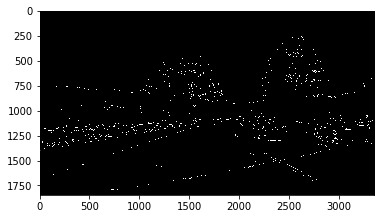

In [20]:


high_threshold = threshold_otsu(img_blur)
print(high_threshold)

low_threshold = int(high_threshold / 2)

img_gradient = cv2.Canny(img_blur, low_threshold, high_threshold)

plt.imshow(img_gradient, cmap='Greys_r')


cv2.imwrite(
    "writeup_images/img_gradient.jpg", 
    img_gradient
)



## Reduce image scope

To detect lanes on the road it will help to reduce the view
of the camera to the road ahead of the car which can be asumed 
to be a triangle formed between:

 - left bottom corner of the image
 - right bottom corner
 - point in the middle by x and 2/3 from the bottom by y

846


True

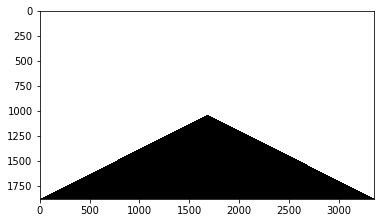

In [7]:
# Demo output of the `limit_view()` function
img_view_demo = np.copy(img_grey) * 0 #creating a blank to draw lines on
img_view_demo = limit_view(img_view_demo, color = 255) # remove color outside of the road view
plt.imshow(img_view_demo, cmap='Greys_r')

cv2.imwrite(
    "writeup_images/img_view_demo.jpg", 
    img_view_demo
)


846


True

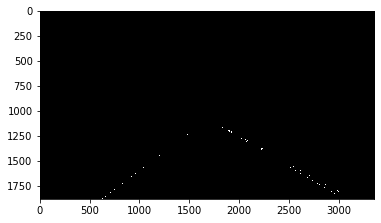

In [8]:
img_limited_view = limit_view(img_gradient)  
plt.imshow(img_limited_view, cmap='Greys_r')


cv2.imwrite(
    "writeup_images/img_limited_view.jpg", 
    img_limited_view
)

Lines detected: 14
Lines merged into: 2


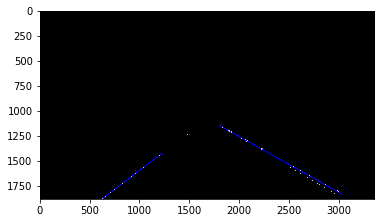

In [9]:
# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 1
theta = np.pi / 180
threshold = 50
min_line_length = 100
max_line_gap = 50

line_image = np.copy(img_limited_view) * 0 #creating a blank to draw lines on

# Run Hough on edge detected image
# OpenCV contains explanation of theory and parameters for HoughLinesP
# https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_houghlines/py_houghlines.html
lines = cv2.HoughLinesP(
    img_limited_view, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

print("Lines detected: {lines}".format(lines = len(lines)))
                  
lines_output = merge_lines(lines)


print("Lines merged into: {output}".format(output = len(lines_output)))

height, width = img_grey.shape

# Iterate over the output "lines" and draw lines on the blank
for line in lines_output:
    for x1, y1, x2, y2 in line:
        cv2.line(line_image, (x1, y1), (x2, y2), 255, 10)
        
        
plt.imshow(line_image)        
        
# Create a "color" binary image to combine with line image
color_edges = np.dstack((img_limited_view, img_limited_view, img_limited_view)) 

plt.imshow(color_edges)
line_image = cv2.merge((np.copy(img_limited_view) * 0, np.copy(img_limited_view) * 0, line_image))
# Draw the lines on the edge image
combo = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 
plt.imshow(combo)

## Result 

Now we can combine lines derived from the pipeline above with original image to visually evaulate performance of the algorithm. 
        
In this example result is only partially satisfactory:

* Continious line on the right side is identified completely
* First section of the broken line on the left side is identified


However, most of segments of the broken line on the left side are undetected. 

There are possible ares for research to improve this:

 * Apply Canny edge detection to the relevant part of the image with different threshold level
 * Apply line detection iteratively over the depth of the image with different threshold levels
   to capture smaller 
 * Interpolate broken lines using the perspective geometry. This pottentially can inform about the shape of the lane based on the other line(s)

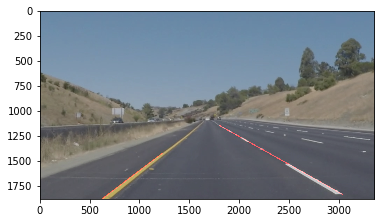

In [10]:
img_demo = img.copy()
img_demo = cv2.addWeighted(img, 0.8, line_image, 1, 0) 
img_demo_color = cv2.cvtColor(img_demo, cv2.COLOR_BGR2RGB)
plt.imshow(img_demo_color)

846


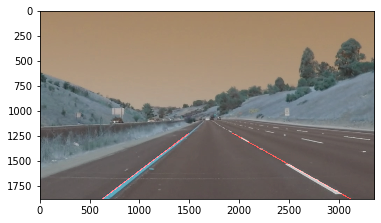

In [11]:
img = cv2.imread(img_path, cv2.IMREAD_COLOR)

res = img_demo2 = process_image(img)
plt.imshow(res)

846


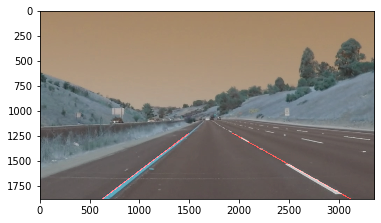

In [12]:
img = cv2.imread(img_path, cv2.IMREAD_COLOR)
res = img_demo2 = process_image(img)
plt.imshow(res)

829


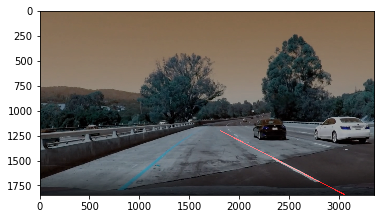

In [13]:
image_path_2 = 'test_images/challenge2.jpg'
img = cv2.imread(image_path_2, cv2.IMREAD_COLOR)
res = img_demo2 = process_image(img)
plt.imshow(res)

846


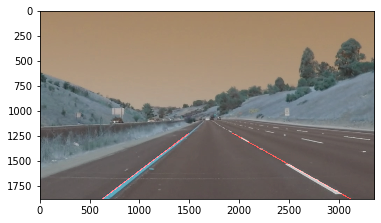

In [14]:
image_path_3 = 'test_images/challenge3.jpg'
img = cv2.imread(image_path_3, cv2.IMREAD_COLOR)
res = process_image(img)
plt.imshow(res)